In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
from imblearn.over_sampling import RandomOverSampler
#!pip install imbalanced-learn
#!pip install statsmodels

In [12]:
# load data
aarp = pd.read_csv('Data/clean_AARP.csv')
aarp.head()

,Unnamed: 0,AGE4,INCOME,D6,D8,D9C,D18,D26,MARITAL,EDUC4,...,AGE4_recode,D6_recode,D8_recode,D9C_recode,D18_recode,D26_recode,MARITAL_recode,EDUC4_recode,RACETHNICITY_recode,GENDER_recode
0,0,60+,"$25,000 to $29,999",Good,Everyday,Never,Self-employed part-time,Rural area,Widowed,BA or above,...,4,3,7,1,1,1,1,4,1,1
1,1,60+,"$40,000 to $49,999",Very good,Several times a week,Rarely,Employed full-time,"Suburban with a mix of offices, apartments and...",Widowed,BA or above,...,4,4,6,2,2,2,1,4,1,2
2,2,30-44,"$100,000 to $124,999",Good,Once every 2 or 3 weeks,Sometimes,Unemployed and looking for work,Rural area,Never married,HS graduate or equivalent,...,2,3,4,3,6,1,2,2,1,1
3,3,30-44,"$200,000 or more",Very good,Everyday,Never,Self-employed full-time,"Urban near mix of offices, apartments and shops",Married,HS graduate or equivalent,...,2,4,7,1,7,2,3,2,2,2
4,4,45-59,"$150,000 to $174,999",Good,Several times a week,Never,Employed full-time,Suburban and mostly residential,Married,Some college,...,3,3,6,1,2,2,3,3,1,1


In [13]:
#looks like this isn't in the form we need it to be
aarp.dtypes

Unnamed: 0              int64
AGE4                   object
INCOME                 object
D6                     object
D8                     object
D9C                    object
D18                    object
D26                    object
MARITAL                object
EDUC4                  object
RACETHNICITY           object
GENDER                 object
HHSIZE                  int64
INCOME_recode           int64
AGE4_recode             int64
D6_recode               int64
D8_recode               int64
D9C_recode              int64
D18_recode              int64
D26_recode              int64
MARITAL_recode          int64
EDUC4_recode            int64
RACETHNICITY_recode     int64
GENDER_recode           int64
dtype: object

In [14]:
#found code to fix that

# list vars
model_vars = ['AGE4_recode', 'D6_recode', 'D8_recode', 'D9C_recode', 'D18_recode', 'D26_recode', 'MARITAL_recode', 'EDUC4_recode', 'RACETHNICITY_recode', 'GENDER_recode', 'HHSIZE', 'INCOME_recode']

# aarp be aarp
aarp = aarp[model_vars]

# recode D9C to binary
# if you never feel SI then 1, else 2, 
# then 0, 1 binary
aarp['is_si'] = aarp['D9C_recode'].apply(lambda x: 1 if x == 1 else 1 if x == 2 else 3)
aarp['is_si'] = aarp['is_si'].apply(lambda x: 0 if x == 1 else 1)

<AxesSubplot:>

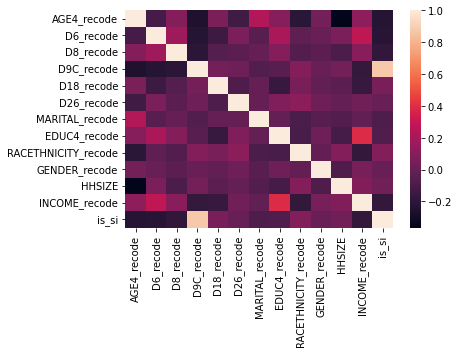

In [15]:
#correlation matrix to prepare for modeling
#D9C was used to make is_si, so thats fine and will be dropped
corr = aarp.corr()
sns.heatmap(corr)

In [16]:
#following Devins lead, recoding nominal variables into dummies
#I believe those are D18 D26 and Marital

aarp = pd.get_dummies(aarp, columns= ['D18_recode', 'D26_recode', 'MARITAL_recode'], prefix= ['D18', 'D26', 'Marital'], drop_first= True)
aarp.head()

,AGE4_recode,D6_recode,D8_recode,D9C_recode,EDUC4_recode,RACETHNICITY_recode,GENDER_recode,HHSIZE,INCOME_recode,is_si,...,D18_4,D18_5,D18_6,D18_7,D26_2,Marital_2,Marital_3,Marital_4,Marital_5,Marital_6
0,4,3,7,1,4,1,1,1,6,0,...,0,0,0,0,0,0,0,0,0,0
1,4,4,6,2,4,1,2,1,9,0,...,0,0,0,0,1,0,0,0,0,0
2,2,3,4,3,2,1,1,6,14,1,...,0,0,1,0,0,1,0,0,0,0
3,2,4,7,1,2,2,2,4,18,0,...,0,0,0,1,1,0,1,0,0,0
4,3,3,6,1,3,1,1,4,16,0,...,0,0,0,0,1,0,1,0,0,0


In [17]:
aarp.columns

Index(['AGE4_recode', 'D6_recode', 'D8_recode', 'D9C_recode', 'EDUC4_recode',
       'RACETHNICITY_recode', 'GENDER_recode', 'HHSIZE', 'INCOME_recode',
       'is_si', 'D18_2', 'D18_3', 'D18_4', 'D18_5', 'D18_6', 'D18_7', 'D26_2',
       'Marital_2', 'Marital_3', 'Marital_4', 'Marital_5', 'Marital_6'],
      dtype='object')

In [18]:
#split into x and y for later modeling
x = aarp[['AGE4_recode', 'D6_recode', 'D8_recode', 'EDUC4_recode',
       'RACETHNICITY_recode', 'GENDER_recode', 'HHSIZE', 'INCOME_recode',
        'D18_2', 'D18_3', 'D18_4', 'D18_5', 'D18_6', 'D18_7', 'D26_2',
       'Marital_2', 'Marital_3', 'Marital_4', 'Marital_5', 'Marital_6']]
y = aarp['is_si']

In [19]:
y.value_counts()

0    1305
1     616
Name: is_si, dtype: int64

In [20]:
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os= SMOTEN(random_state= 42)
os_x, os_y= os.fit_resample(x_train, y_train)

In [21]:
#it is balanced
os_y.value_counts()

1    926
0    926
Name: is_si, dtype: int64

In [22]:
#insignificant vars are: D8_recode, RACETHNICITY_recode, GENDER_recode, HHSIZE, D18_6, D26_2, Marital_5

import statsmodels.api as sm

sm_logit = sm.Logit(os_y, os_x)
result = sm_logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.621180
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                 1852
Model:                          Logit   Df Residuals:                     1832
Method:                           MLE   Df Model:                           19
Date:                Tue, 04 Apr 2023   Pseudo R-squ.:                  0.1038
Time:                        11:08:25   Log-Likelihood:                -1150.4
converged:                       True   LL-Null:                       -1283.7
Covariance Type:            nonrobust   LLR p-value:                 1.344e-45
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
AGE4_recode            -0.1665      0.063     -2.622      0.009      -0.291      -0.042
D6

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

sk_logit = LogisticRegression()
sk_logit.fit(os_x, os_y)
y_pred = sk_logit.predict(x_test)
print('Accuracy on test set:{:.2f}'.format(sk_logit.score(x_test, y_test)))

Accuracy on test set:0.69


C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       379
           1       0.55      0.54      0.54       198

    accuracy                           0.69       577
   macro avg       0.65      0.65      0.65       577
weighted avg       0.69      0.69      0.69       577



In [29]:
for ages in aarp['AGE4_recode'].unique():
    
    # grab aarp for single age group
    aged_aarp = aarp.loc[aarp['AGE4_recode'] == ages]
    
    # split into train and test
    aarp_train, aarp_test = train_test_split(aged_aarp, test_size=0.33, random_state=42)
    
    #################################### IMBALANCE LEARN ####################################
    # upsample train set
    # first we need the indexes of the categorical columns
#     cat_idxs =[]
#     for idx, dtype in zip(range(len(aged_aarp.dtypes)), aged_aarp.dtypes):
#         if dtype == 'category':
#             cat_idxs.append(idx)
            
    # then create our imbalance object
    sm = RandomOverSampler(random_state=42)
    
    #################################### IMBALANCE LEARN ####################################
    # manually create x,y test and trains
    x_train = aarp_train[['AGE4_recode', 'D6_recode', 'D8_recode', 'EDUC4_recode',
       'RACETHNICITY_recode', 'GENDER_recode', 'HHSIZE', 'INCOME_recode',
        'D18_2', 'D18_3', 'D18_4', 'D18_5', 'D18_6', 'D18_7', 'D26_2',
       'Marital_2', 'Marital_3', 'Marital_4', 'Marital_5', 'Marital_6']]
    x_test = aarp_test[['AGE4_recode', 'D6_recode', 'D8_recode', 'EDUC4_recode',
       'RACETHNICITY_recode', 'GENDER_recode', 'HHSIZE', 'INCOME_recode',
        'D18_2', 'D18_3', 'D18_4', 'D18_5', 'D18_6', 'D18_7', 'D26_2',
       'Marital_2', 'Marital_3', 'Marital_4', 'Marital_5', 'Marital_6']]
    y_train = aarp_train['is_si']
    y_test = aarp_test['is_si']
    
    #################################### IMBALANCE LEARN ####################################
    x_train, y_train = sm.fit_resample(x_train, y_train)
    #################################### IMBALANCE LEARN ####################################
    
    # new logistic regression model
    sk_logit = LogisticRegression()
    
    # let's 'train'
    sk_logit.fit(x_train, y_train)
    
    # print the results
    print(f'\n---------- score for age {ages}: {round(sk_logit.score(x_test, y_test),3)}% ----------')
        
    ###### print train and test set sizes
    print(f'\ntraining set size: \n{y_train.value_counts()}')
    print(f'testing set size:  \n{y_test.value_counts()}')
    ###### 


---------- score for age 4: 0.693% ----------

training set size: 
1    253
0    253
Name: is_si, dtype: int64
testing set size:  
0    124
1     29
Name: is_si, dtype: int64

---------- score for age 2: 0.635% ----------

training set size: 
0    241
1    241
Name: is_si, dtype: int64
testing set size:  
0    117
1     61
Name: is_si, dtype: int64

---------- score for age 3: 0.639% ----------

training set size: 
1    221
0    221
Name: is_si, dtype: int64
testing set size:  
0    103
1     44
Name: is_si, dtype: int64

---------- score for age 1: 0.642% ----------

training set size: 
1    162
0    162
Name: is_si, dtype: int64
testing set size:  
0    84
1    75
Name: is_si, dtype: int64


C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [35]:
for ages in aarp['AGE4_recode'].unique():
    
    # grab aarp for single age group
    aged_aarp = aarp.loc[aarp['AGE4_recode'] == ages]
    
    # split into train and test
    aarp_train, aarp_test = train_test_split(aged_aarp, test_size=0.33, random_state=42)
    
    #################################### IMBALANCE LEARN ####################################
    # upsample train set
    # first we need the indexes of the categorical columns
#     cat_idxs =[]
#     for idx, dtype in zip(range(len(aged_aarp.dtypes)), aged_aarp.dtypes):
#         if dtype == 'category':
#             cat_idxs.append(idx)
            
    # then create our imbalance object
    from imblearn.over_sampling import SMOTEN
    ab = SMOTEN(random_state=42)
    
    
    #################################### IMBALANCE LEARN ####################################
    # manually create x,y test and trains
    x_train = aarp_train[['AGE4_recode', 'D6_recode', 'D8_recode', 'EDUC4_recode',
       'RACETHNICITY_recode', 'GENDER_recode', 'HHSIZE', 'INCOME_recode',
        'D18_2', 'D18_3', 'D18_4', 'D18_5', 'D18_6', 'D18_7', 'D26_2',
       'Marital_2', 'Marital_3', 'Marital_4', 'Marital_5', 'Marital_6']]
    x_test = aarp_test[['AGE4_recode', 'D6_recode', 'D8_recode', 'EDUC4_recode',
       'RACETHNICITY_recode', 'GENDER_recode', 'HHSIZE', 'INCOME_recode',
        'D18_2', 'D18_3', 'D18_4', 'D18_5', 'D18_6', 'D18_7', 'D26_2',
       'Marital_2', 'Marital_3', 'Marital_4', 'Marital_5', 'Marital_6']]
    y_train = aarp_train['is_si']
    y_test = aarp_test['is_si']
    
    #################################### IMBALANCE LEARN ####################################
    x_train, y_train = ab.fit_resample(x_train, y_train)
    #################################### IMBALANCE LEARN ####################################
    
    print(y_test.unique())
    
    #import for stats model
    import statsmodels.api as sm
    
    # new logistic regression model
    sm_logit = sm.Logit(x_train, y_train)
    result = sm_logit.fit()
    
    # print the results
    print(f'\n---------- score for age {ages}: % ----------')
    print(result.summary())
        
    ###### print train and test set sizes
    print(f'\ntraining set size: \n{y_train.value_counts()}')
    print(f'testing set size:  \n{y_test.value_counts()}')
    ###### 

[0 1]


ValueError: endog must be in the unit interval.